# How Do Stats Stabilize?
### MSP 05.11.2017

How large of a sample size do we need to trust a given statistic?

Building off of analyzing batting average, we want to take individual games and find out what range of games (or PAs, or ABs, or pitches) we have to consider in order to get a picture of who a player actually is.

### Part I: Hitting Ratios


In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from random import randrange
import scipy.stats as sst




In [3]:
# now read in all the data: it's a lot, but is set up this way so that
#  we can slice across batting order.

#
# general fangraphs data for players
#
# all with > 100 PA at given lineup position

def read_batting_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG","playerid"),\
                         'formats': ('S20','S20','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4','i2')},\
                 skip_header=1,delimiter=',')
    return BatData


def read_individual_game_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Date","Team","Opp","BO","Pos","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG"),\
                         'formats': ('S20','S20','S20','i2','S4','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4')},\
                 skip_header=2,delimiter=',')
    return BatData


Beltre2016 = read_individual_game_data('../batting_notebooks/2016Batting/BeltreLog2016.csv')
Trout2016 = read_individual_game_data('../batting_notebooks/2016Batting/TroutLog2016.csv')

Altuve2016 = read_individual_game_data('../batting_notebooks/2016Batting/AltuveLog2016.csv')
Altuve2017 = read_individual_game_data('../batting_notebooks/2016Batting/AltuveLog2017.csv')


Lemahieu2016 = read_individual_game_data('../batting_notebooks/2016Batting/LemahieuLog2016.csv')
Lemahieu2017 = read_individual_game_data('../batting_notebooks/2016Batting/LemahieuLog2017.csv')



Total2016   = read_batting_data('../batting_notebooks/2016Batting/TotalBatting.csv')



# the spreadsheet below has been adjusted to skip 'des', which routinely has commas. C'mon guys! This needs to be machine readable!
def read_statcast_data(infile):
    outdict = np.genfromtxt(infile,\
        dtype={'names': ("pitch_type","game_date",\
                         "release_speed","x0","z0","player_name","batter","pitcher",\
                         "events","description","spin_dir","spin_rate","break_angle",\
                         "break_length","zone","game_type","stand","p_throws",\
                         "home_team","away_team","type","hit_location","bb_type",\
                         "balls","strikes","game_year","pfx_x","pfx_z","px","pz",\
                         "on_3b","on_2b","on_1b","outs_when_up","inning","inning_topbot",\
                         "hc_x","hc_y","tfs","tfs_zulu","catcher","umpire","sv_id",\
                         "vx0","vy0","vz0","ax","ay","az","sz_top","sz_bot","hit_distance_sc",\
                         "launch_speed","launch_angle","effective_speed","release_spin_rate",\
                         "release_extension","game_pk",\
                         "pos1_id","pos2_id","pos3_id",\
                         "pos4_id","pos5_id","pos6_id",\
                         "pos7_id","pos8_id","pos9_id",\
                         "release_pos_y","estimated_ba_using_speedangle","estimated_woba_using_speedangle",\
                         "woba_value","woba_denom","babip_value","iso_value"),\
                'formats': ('S2','S20',\
                            'f4','S20','S20','S20','S20','S20',\
                            'S40','S40','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','f4','f4','f4','f4',\
                            'S20','S20','S20','S20','S20','S20',\
                            'f4','f4','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20','S20','S20',\
                            'f4','f4','f4','f4',
                            'S20','S20',\
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4','f4')},\
                 skip_header=1,delimiter=',')
    return outdict


AugustHits = read_statcast_data('../batting_notebooks/2016Batting/August2016Hits.csv')

AugustOuts = read_statcast_data('../batting_notebooks/2016Batting/August2016Outs.csv')






In [4]:

def player_map(player):
    ghits = np.where( (AugustHits['launch_speed'] != 90) | (AugustHits['launch_angle'] > 0))[0]

    ghits = np.where( (AugustOuts['player_name']==player))

    ohits = np.where( (AugustHits['player_name']==player))


    #plt.scatter(128.-AugustHits['hc_x'],204.-AugustHits['hc_y'],color='black',s=1.)
    #plt.scatter(128.-AugustOuts['hc_x'],204.-AugustOuts['hc_y'],color='red',s=0.2)


    xbnds = np.array([-100.,100.])
    ybnds = np.array([-30.,200.])
    extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]

    fig=plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    #x, y = points.T
    # Set gridsize just to make them visually large
    image = plt.hexbin(AugustOuts['hc_x']-125.4,197.3-AugustOuts['hc_y'],cmap=plt.cm.gnuplot,gridsize=31,extent=extent,mincnt=1,bins='log')

    plt.scatter(AugustOuts['hc_x'][ghits]-125.4,197.3-AugustOuts['hc_y'][ghits],facecolor='none',edgecolor='white',s=10.)

    plt.scatter(AugustHits['hc_x'][ohits]-125.4,197.3-AugustHits['hc_y'][ohits],facecolor='none',edgecolor='black',s=10.)


    # Note that mincnt=1 adds 1 to each count
    counts = image.get_array()
    ncnts = np.count_nonzero(np.power(10,counts))
    verts = image.get_offsets()
    #for offc in xrange(verts.shape[0]):
    #    binx,biny = verts[offc][0],verts[offc][1]
    #    if counts[offc]:
    #        plt.plot(binx,biny,'k.',zorder=100)

    ax.set_xlim(xbnds)
    ax.set_ylim(ybnds)

    plt.title(player+' August 2016')

    plt.grid(True)
    cb = plt.colorbar(image,spacing='uniform')#,extend='max')
    cb.set_label('Frequency')
    plt.show()




    xbins = np.linspace(50.,120.,30)
    ybins = np.linspace(-30.,70.,30)

    ghits = np.where( (AugustHits['launch_speed'] != 90) | (AugustHits['launch_angle'] > 0))[0]

    H, xedges, yedges = np.histogram2d(AugustHits['launch_speed'][ghits],AugustHits['launch_angle'][ghits], \
                                       bins=(xbins,ybins))
    H = H.T/np.sum(H) # Let each row list bins with common y range.


    ghits = np.where( (AugustOuts['launch_speed'] != 90) | (AugustOuts['launch_angle'] > 0))[0]

    G, xedges, yedges = np.histogram2d(AugustOuts['launch_speed'][ghits],AugustOuts['launch_angle'][ghits], \
                                       bins=(xbins,ybins))
    G = G.T/np.sum(G)  # Let each row list bins with common y range.



    fig,ax = plt.subplots(figsize=(2,2))
    ax.set_title('August 2016 Hits')
    X, Y = np.meshgrid(xedges, yedges)
    X2, Y2 = np.meshgrid(xbins,ybins)
    ax.pcolormesh(X, Y, H/(G+1.),cmap=cm.Greys)
    ax.set_ylabel('Launch Angle\n(degrees)')
    ax.set_xlabel('Launch Speed\n(MPH)')

    ohits = np.where( (AugustHits['player_name']==player))

    ax.scatter(AugustHits['launch_speed'][ohits],AugustHits['launch_angle'][ohits],edgecolor='red',facecolor='none',s=10.)


    for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")

    ax.axis([50,115,-20,60])
    
    

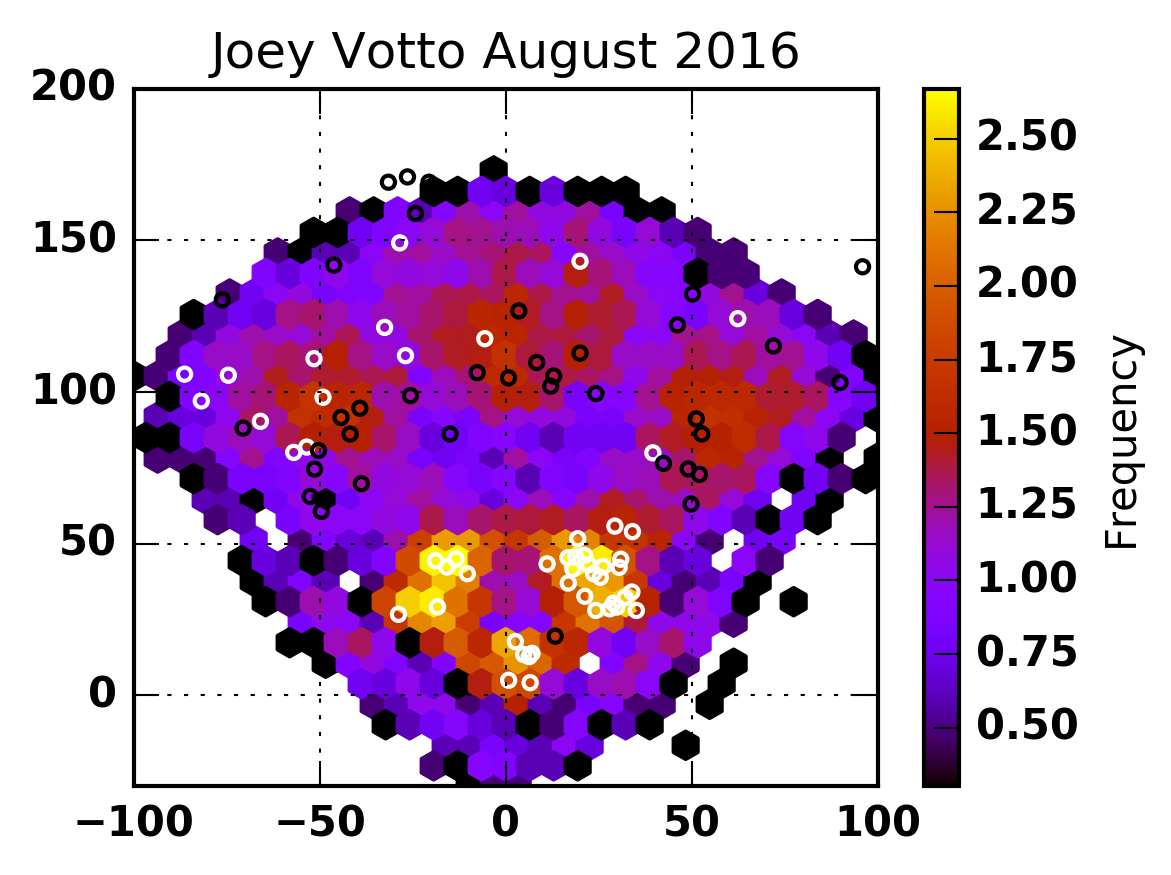

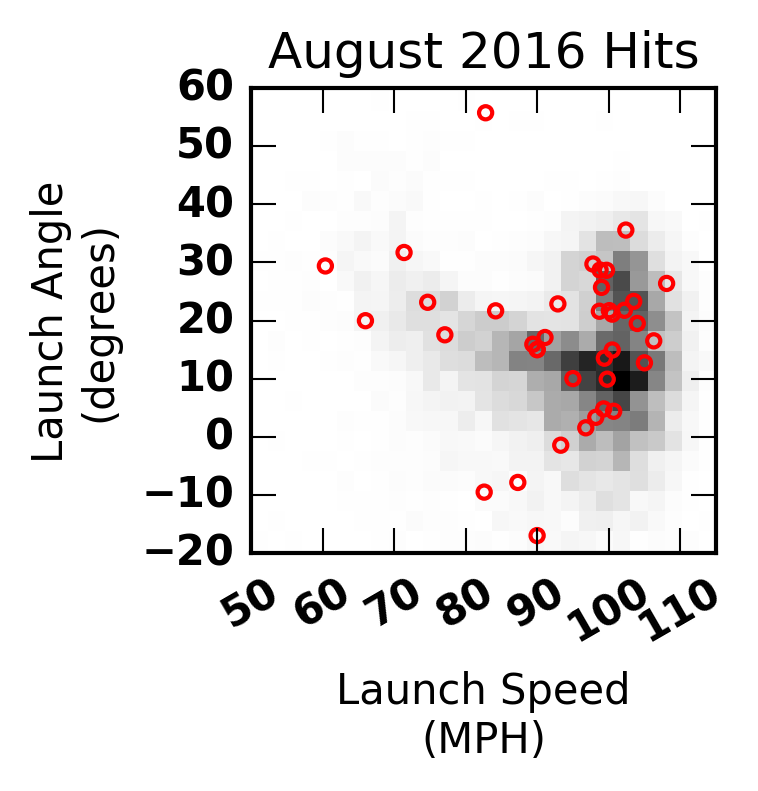

In [5]:
player_map('Joey Votto')

Let's look at where those hits fell in the velocity-angle plane.

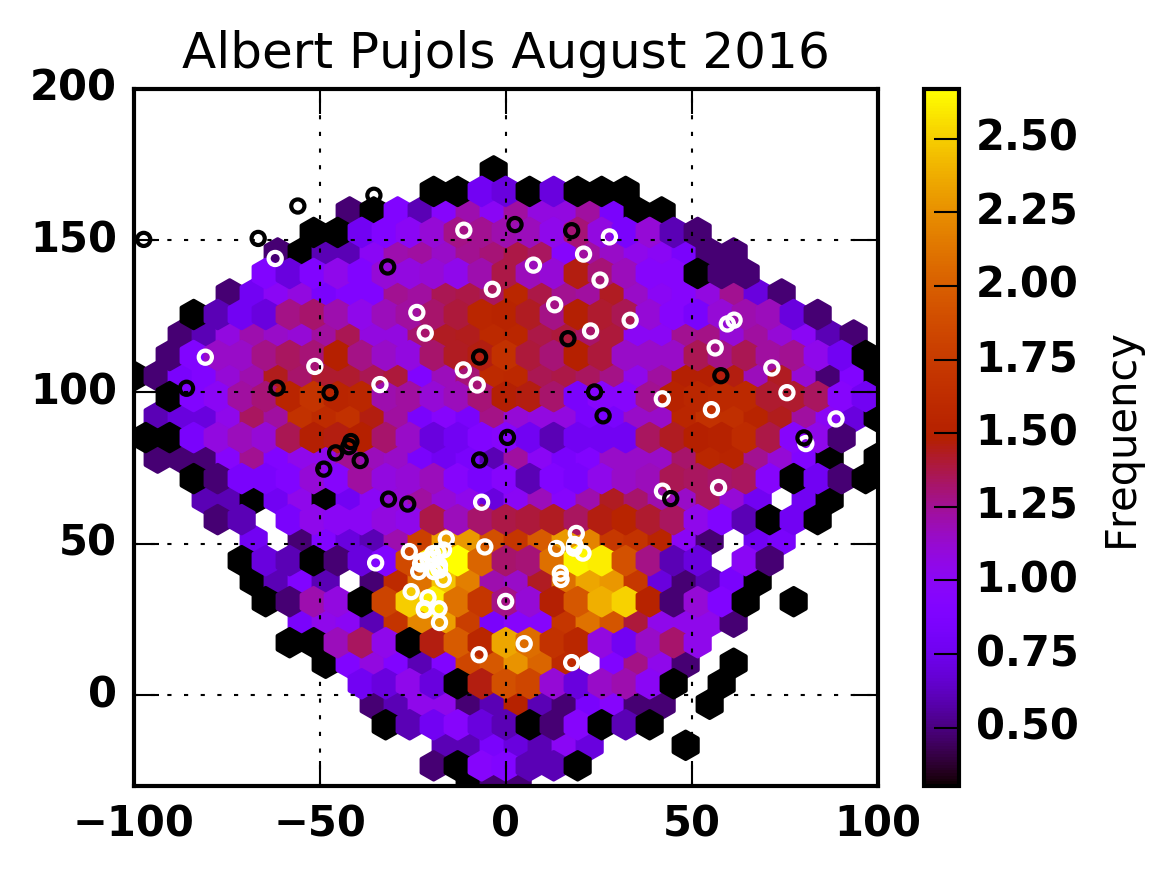

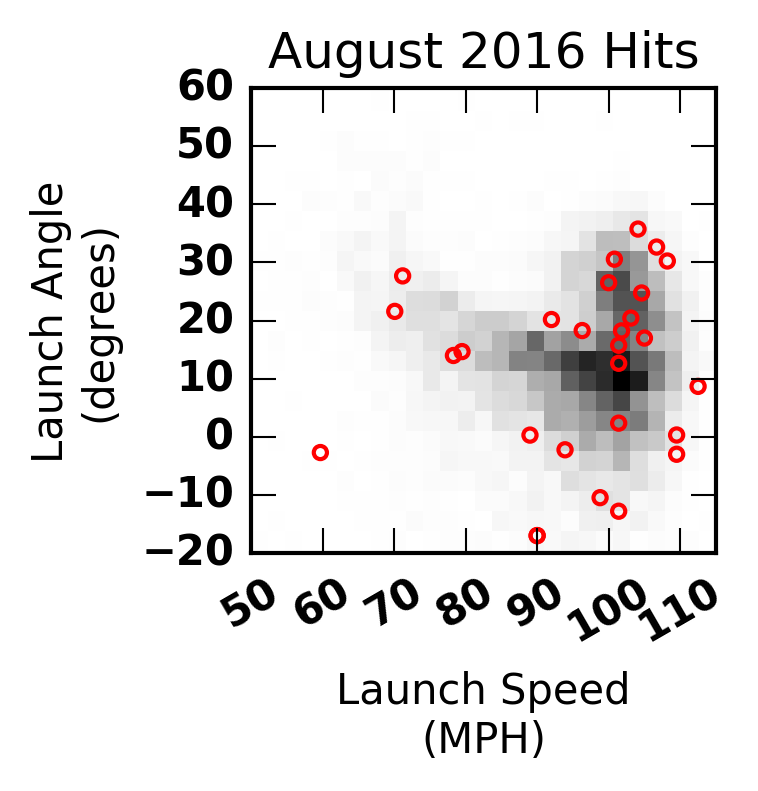

In [6]:
player_map('Albert Pujols')

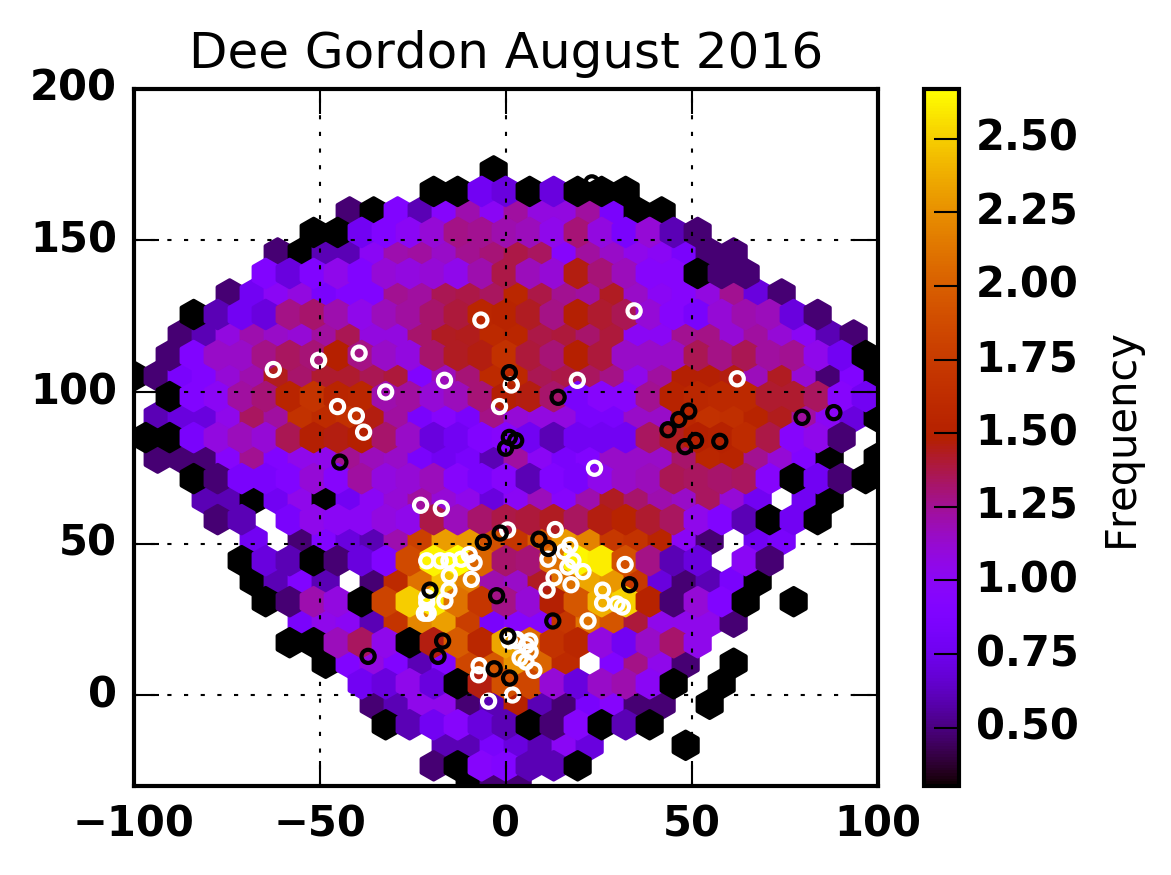

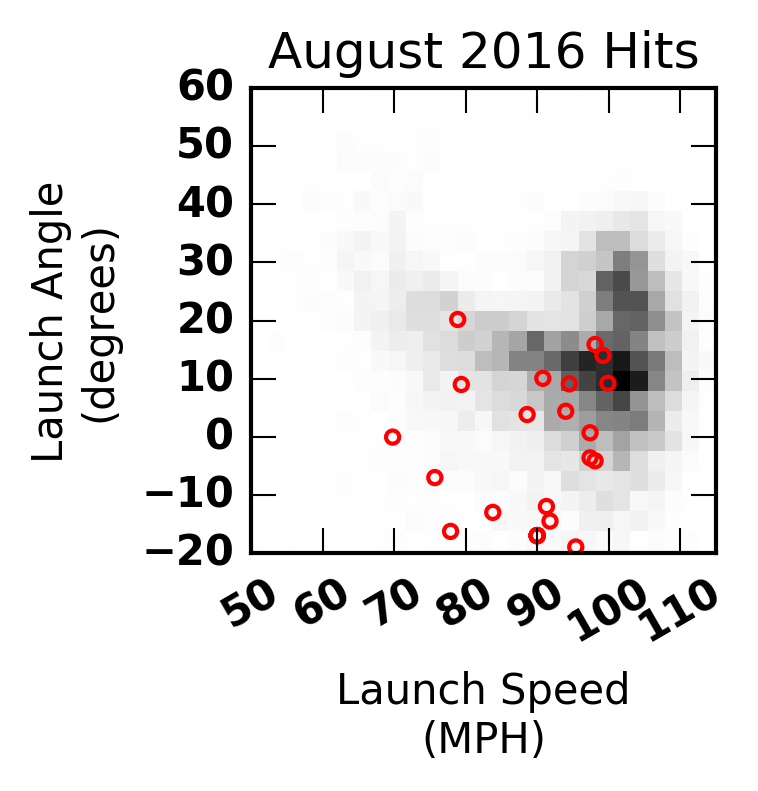

In [7]:
player_map('Dee Gordon')

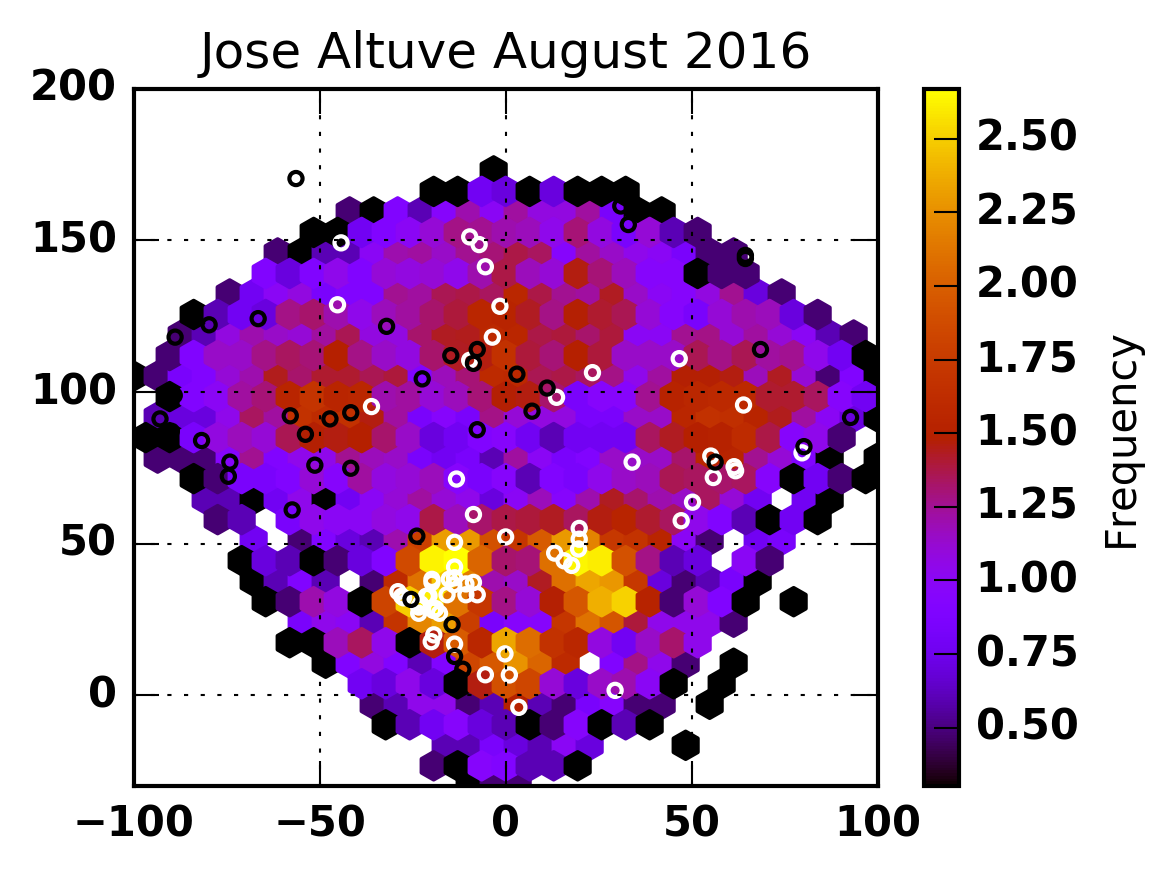

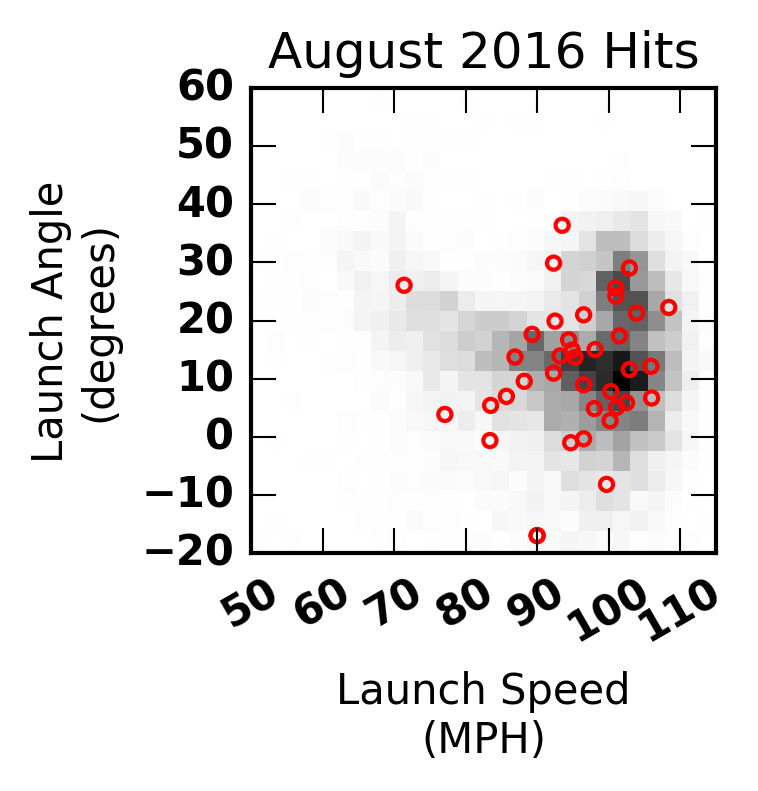

In [8]:
player_map('Jose Altuve')

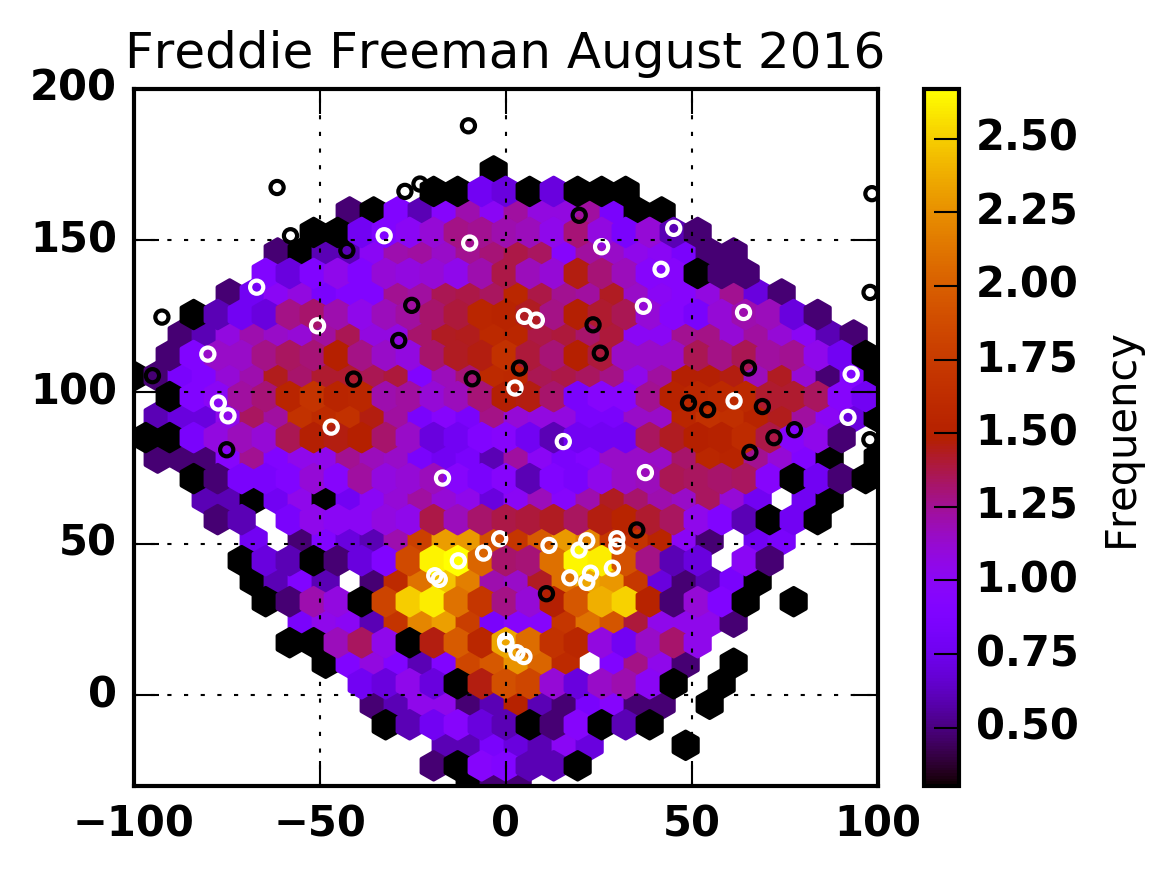

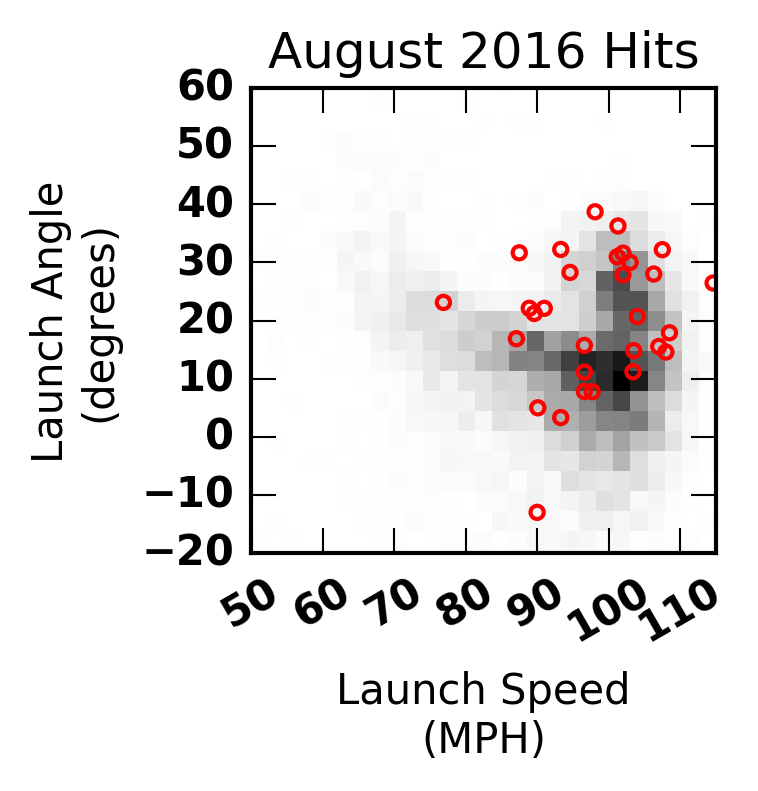

In [9]:
player_map('Freddie Freeman')

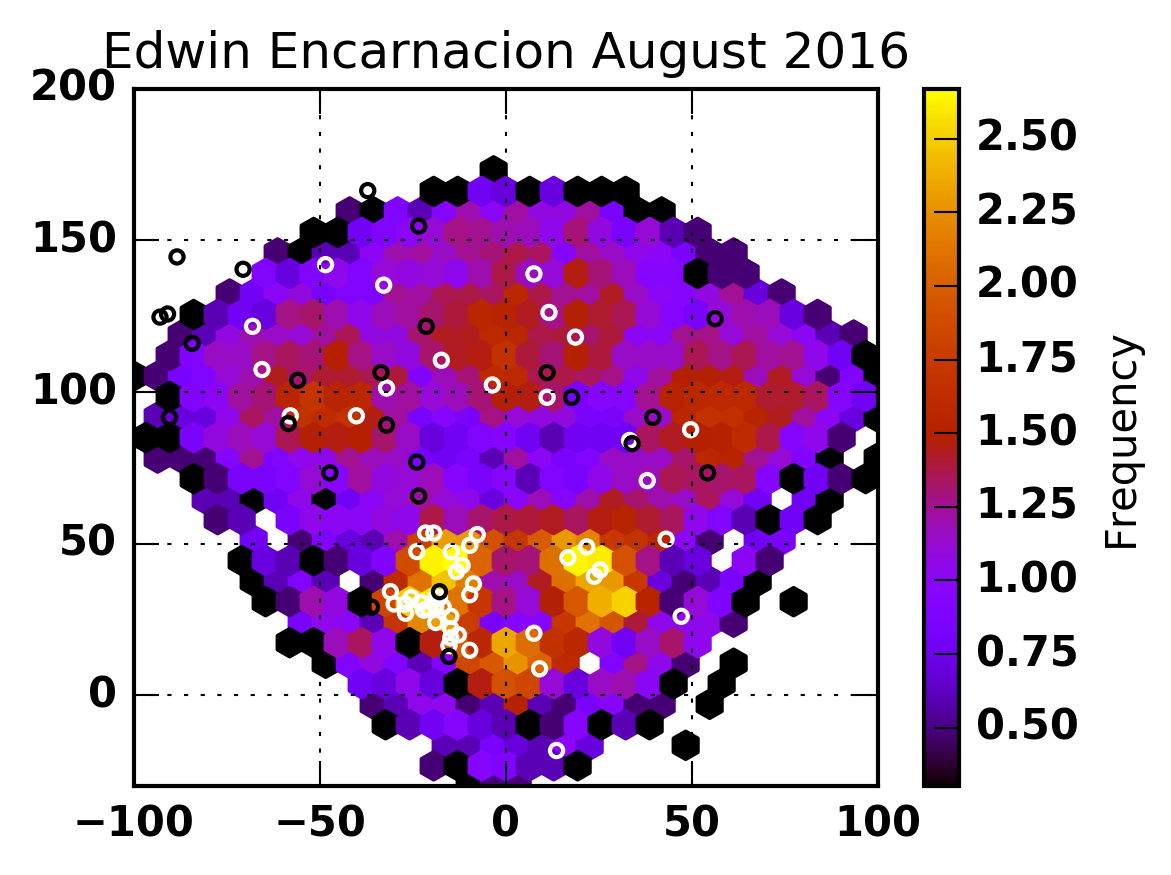

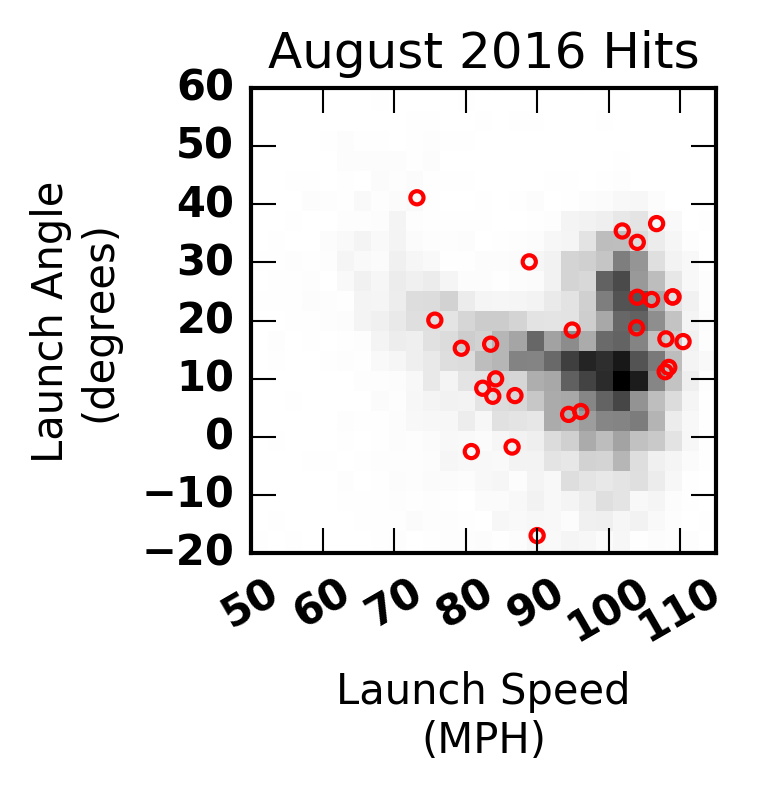

In [10]:
player_map('Edwin Encarnacion')

### For next week: looking at individual pitches

In [11]:
def read_statcast_data(infile):
    outdict = np.genfromtxt(infile,\
        dtype={'names': ("pitch_type","pitch_id","game_date",\
                         "start_speed","x0","z0","player_name","batter","pitcher",\
                         "events","description","spin_dir","spin_rate","break_angle",\
                         "break_length","zone","des","game_type","stand","p_throws",\
                         "home_team","away_team","type","hit_location","bb_type",\
                         "balls","strikes","game_year","pfx_x","pfx_z","px","pz",\
                         "on_3b","on_2b","on_1b","outs_when_up","inning","inning_topbot",\
                         "hc_x","hc_y","tfs","tfs_zulu","catcher","umpire","sv_id",\
                         "vx0","vy0","vz0","ax","ay","az","sz_top","sz_bot","hit_distance_sc",\
                         "hit_speed","hit_angle","effective_speed","release_spin_rate",\
                         "release_extension","game_pk"),\
                'formats': ('S2','S20','S20',\
                            'f4','S20','S20','S20','S20','S20',\
                            'S40','S40','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'i2','i2','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20','S20','S20',\
                            'f4','f4','f4','f4',
                            'S20','S20')},\
                 skip_header=1,delimiter=',')
    return outdict

Syndergaard2016   = read_statcast_data('../pitching_notebooks/2016Pitching/Syndergaard2016.csv')
Syndergaard2017   = read_statcast_data('../pitching_notebooks/2016Pitching/Syndergaard2017_041017.csv')

In [12]:
count_grid2017 = np.zeros([4,3])
for indx in range(0,Syndergaard2017['balls'].size):
    count_grid2017[Syndergaard2017['balls'][indx],Syndergaard2017['strikes'][indx]] += 1
    
count_grid2016 = np.zeros([4,3])
for indx in range(0,Syndergaard2016['balls'].size):
    count_grid2016[Syndergaard2016['balls'][indx],Syndergaard2016['strikes'][indx]] += 1
    
print ('In 2016, Noah Syndergaard threw a first pitch strike {0:4.1f}% of the time.'\
       .format(100.*count_grid2016[0,1]/np.sum([count_grid2016[1,0],count_grid2016[0,1]])))

print ('In the first two outings of 2017, Noah Syndergaard threw a first pitch strike {0:4.1f}% of the time.'\
       .format(100.*count_grid2017[0,1]/np.sum([count_grid2017[1,0],count_grid2017[0,1]])))

In 2016, Noah Syndergaard threw a first pitch strike 60.0% of the time.
In the first two outings of 2017, Noah Syndergaard threw a first pitch strike 45.5% of the time.


In [13]:
GameDict = {}
for yy in range(0,Syndergaard2016['tfs_zulu'].size):
    x = Syndergaard2016['tfs_zulu'][yy]
    gameday = x.split('T')[0]
    gametime = np.sum(60.*np.array([3600.,60.,1.])*\
                      np.array([float(y) for y in (x.split('T')[-1][0:-1]).split(':')]))
    if gameday not in GameDict.keys():
        GameDict[gameday] = {}
        #GameDict[gameday][gametime] = Syndergaard2016['start_speed'][yy]
        GameDict[gameday][gametime] = Syndergaard2016['description'][yy]
    else:
        #GameDict[gameday][gametime] = Syndergaard2016['start_speed'][yy]
        GameDict[gameday][gametime] = Syndergaard2016['description'][yy]
        
print('Noah Syndergaard pitched:')
for yy in GameDict.keys(): print(yy)

Noah Syndergaard pitched:
2016-08-11
2016-04-12
2016-08-17
2016-07-19
2016-06-08
2016-07-26
2016-09-13
2016-04-05
2016-09-14
2016-09-19
2016-04-25
2016-04-26
2016-06-27
2016-06-09
2016-06-22
2016-06-04
2016-05-18
2016-06-01
2016-06-03
2016-06-28
2016-05-17
2016-05-28
2016-05-12
2016-04-13
2016-07-08
2016-07-03
2016-08-06
2016-08-05
2016-07-20
2016-08-28
2016-05-01
2016-08-27
2016-07-09
2016-08-22
2016-09-28
2016-05-22
2016-04-19
2016-09-20
2016-09-07
2016-09-27
2016-09-02
2016-09-03
2016-05-07
2016-06-16
2016-06-15
2016-04-18
2016-07-31


In [14]:
w = np.where(Syndergaard2016['description'] == 'Swinging Strike')[0]
print len(w)

Syndergaard2016['description'][0:20]

#'Ball In Dirt'
#'Foul'
#'Called Strike'
#'Swinging Strike'

388


array(['Ball In Dirt', 'Foul', 'Foul', 'Ball', 'Called Strike', 'Foul',
       'Ball', 'In play run(s)', 'Called Strike', 'Foul', 'Called Strike',
       'In play out(s)', 'Ball', 'In play out(s)', 'Ball', 'Foul',
       'Called Strike', 'Swinging Strike', 'Called Strike', 'Ball'], 
      dtype='|S40')

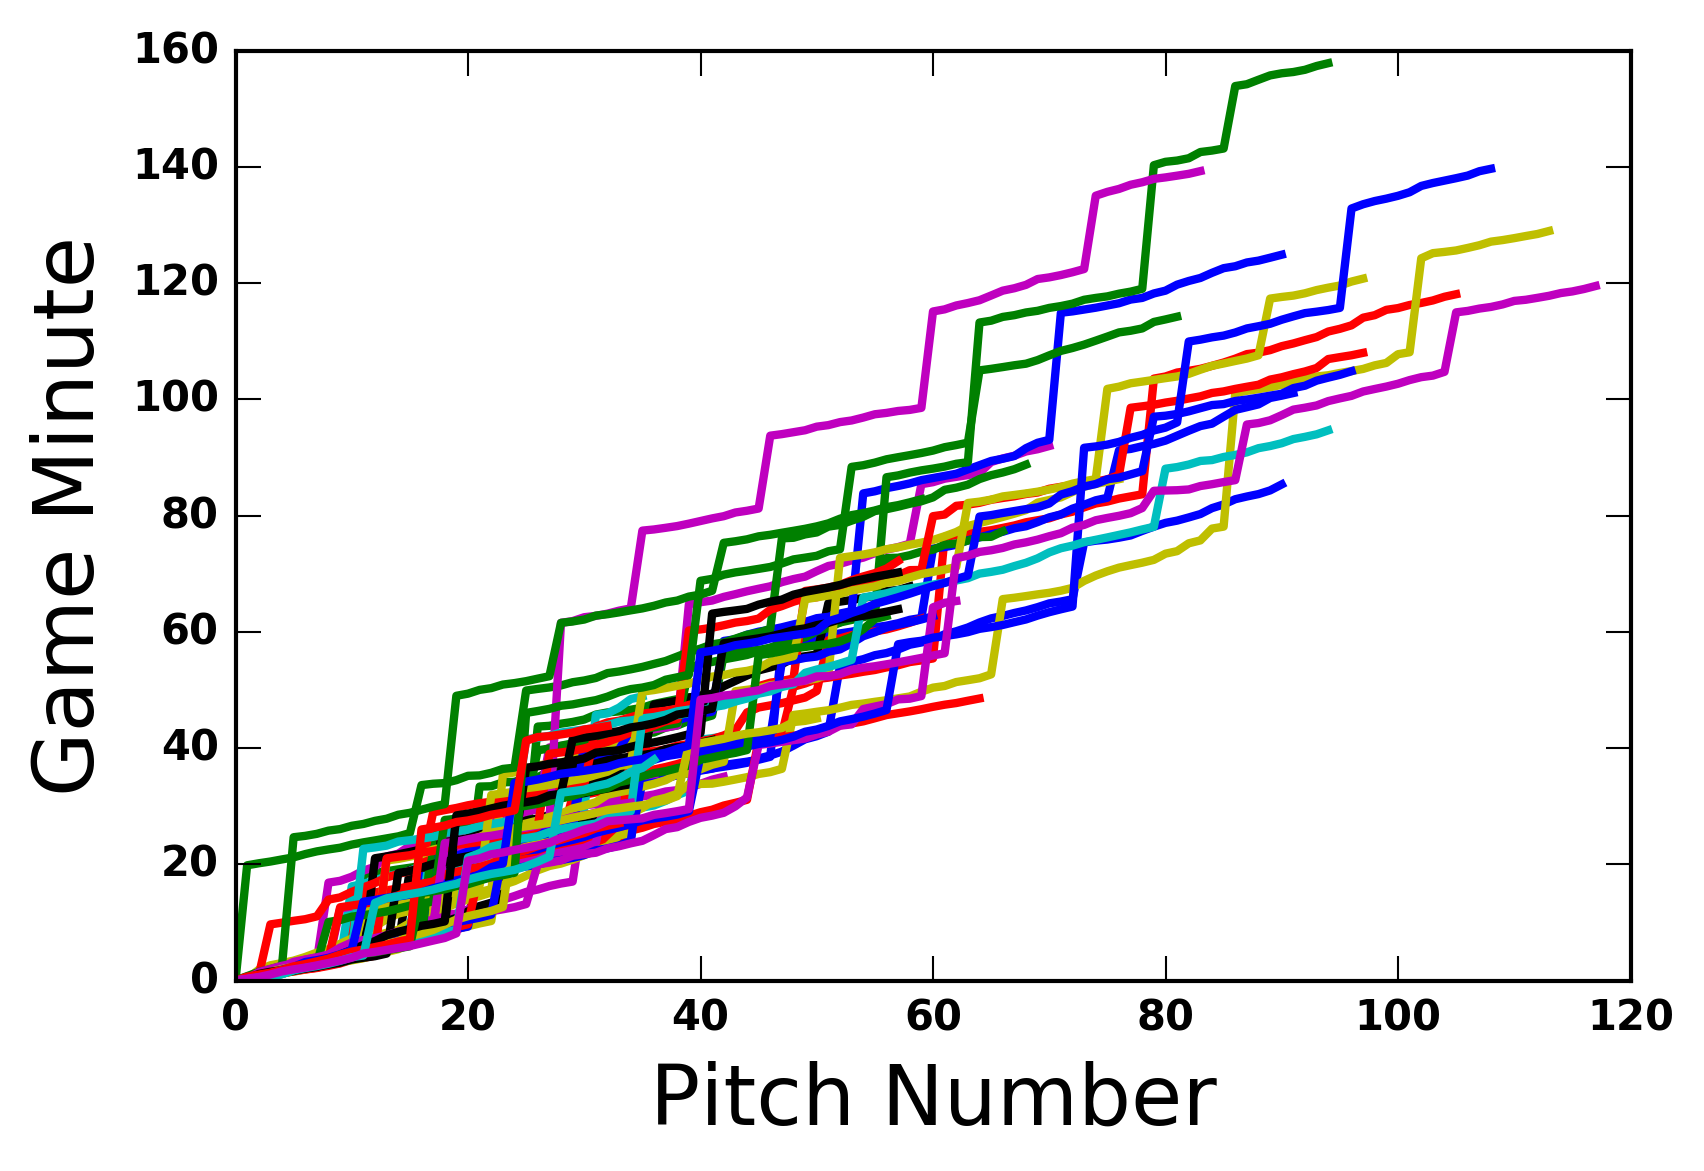

In [15]:
#pitch_times = np.array([np.round(x/3600.,3) for x in GameDict['2017-04-10'].keys()])
#plt.plot(pitch_times[pitch_times.argsort()]-np.min(pitch_times))

for z in GameDict.keys():
    pitch_times = np.array([np.round(x/3600.,3) for x in GameDict[z].keys()])
    plt.plot(pitch_times[pitch_times.argsort()]-np.min(pitch_times))
    
_ = plt.xlabel('Pitch Number',size=20)
_ = plt.ylabel('Game Minute',size=20)

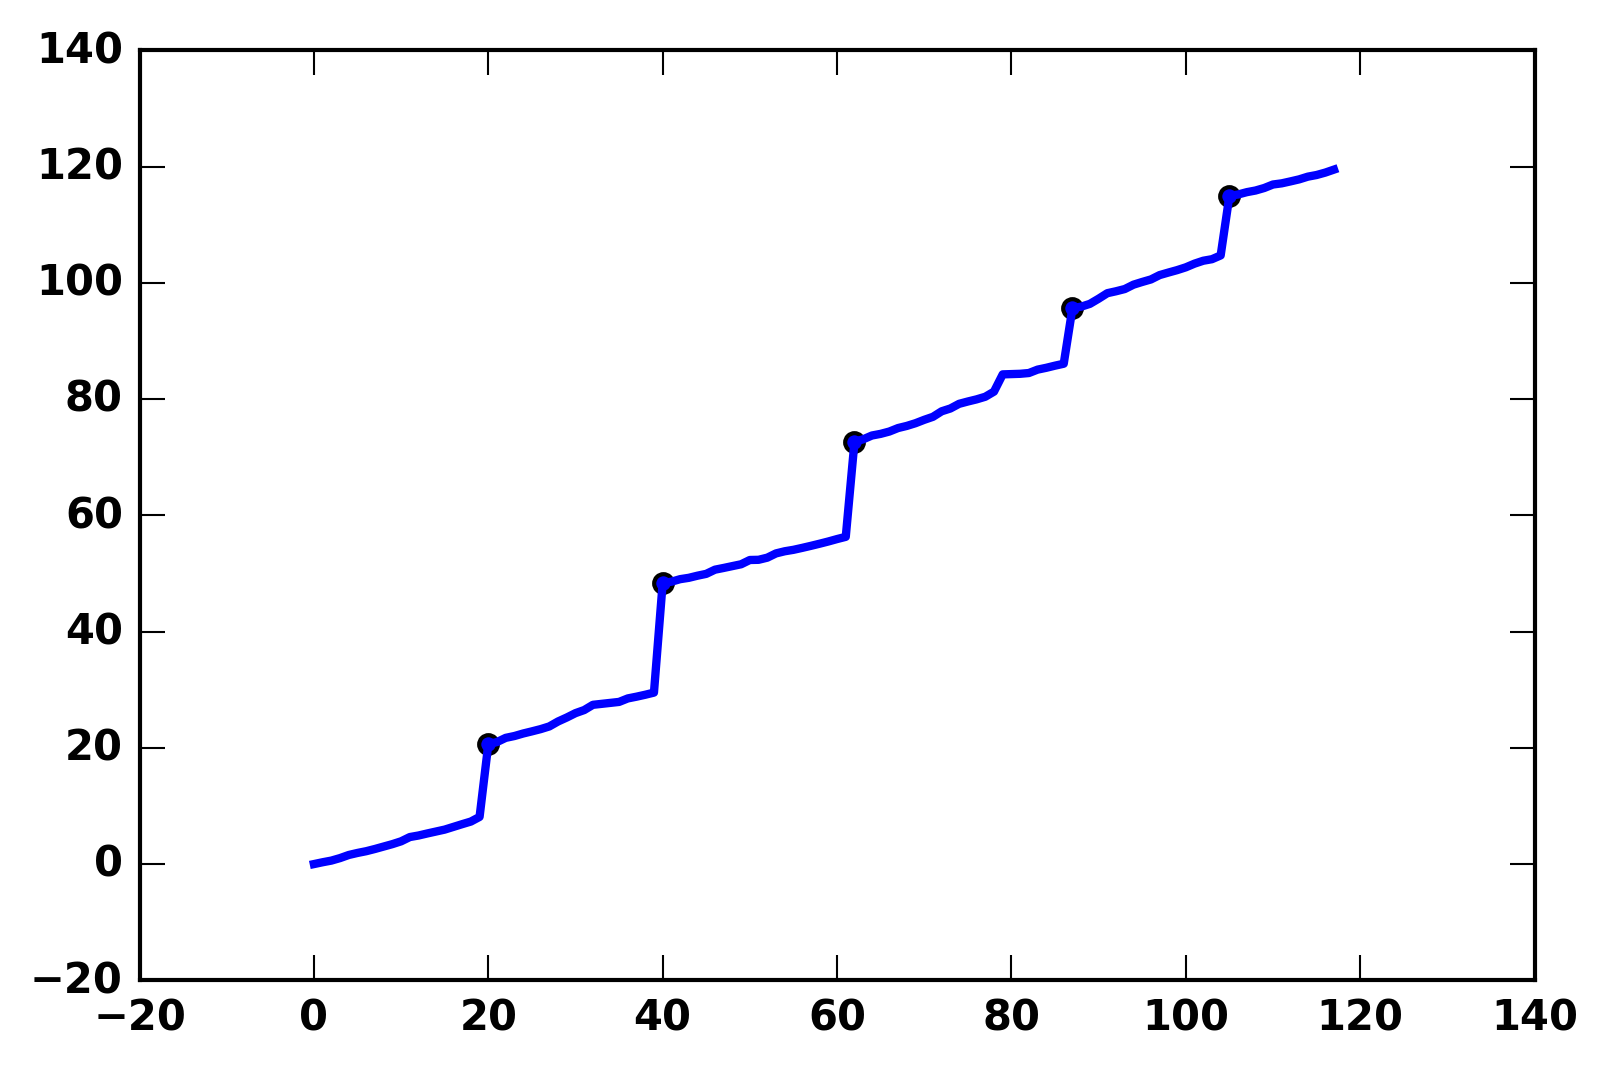

In [16]:
pitch_times = np.array([np.round(x/3600.,3) for x in GameDict['2016-07-31'].keys()])
pt = pitch_times[pitch_times.argsort()]-np.min(pitch_times)
    
plt.plot(pt)
    
# this is the start of the next inning
w = np.where(np.ediff1d(pt,to_begin=0.) > 5.)

plt.scatter(w,pt[w])


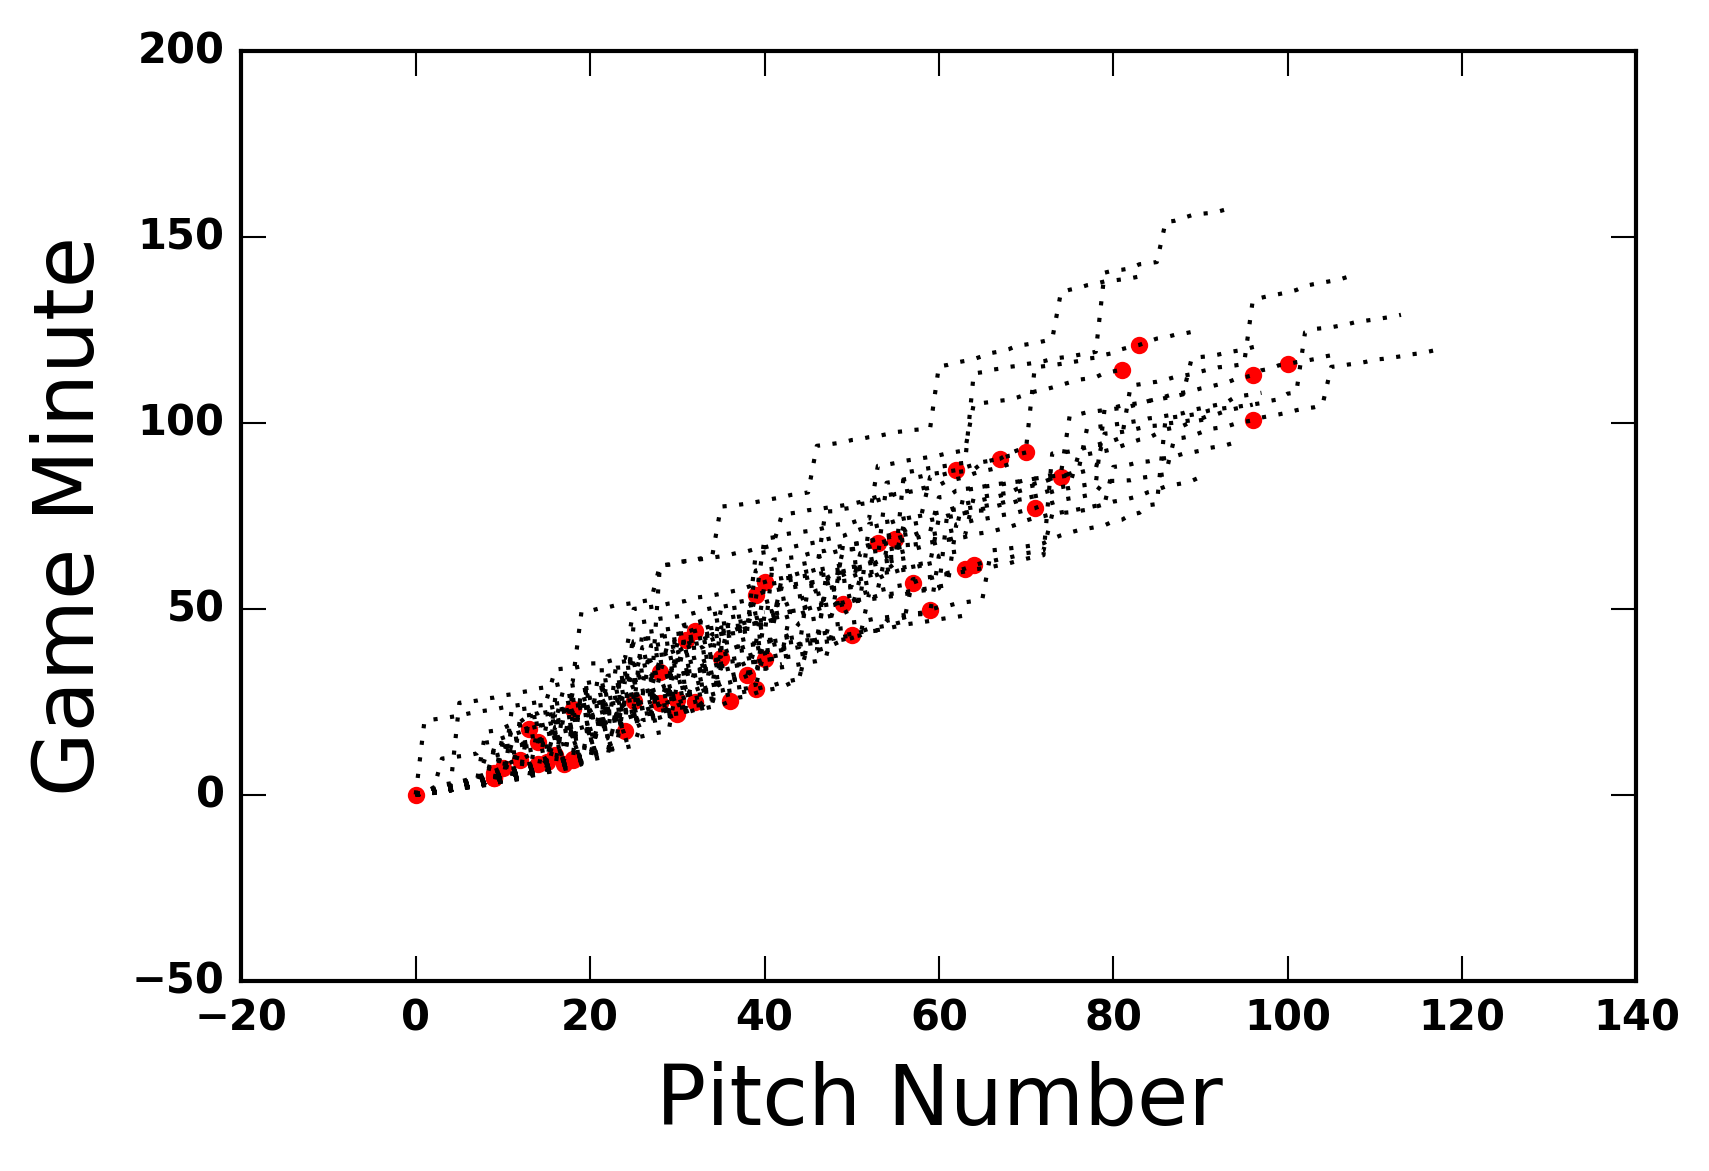

In [17]:

for z in GameDict.keys():
    pitch_times = np.array([np.round(x/3600.,3) for x in GameDict[z].keys()])
    outcome = np.array([GameDict[z][x] for x in GameDict[z].keys()])
    org_pitch = pitch_times[pitch_times.argsort()]
    org_outcome = outcome[pitch_times.argsort()]
    w = np.where(np.ediff1d(org_pitch,to_begin=0.) > 5.)
    plt.plot(org_pitch-np.min(pitch_times),color='black',linestyle='dotted',lw=1.)
    w = np.where(org_outcome == 'In play run(s)')
    plt.scatter(w,org_pitch[w]-np.min(pitch_times),color='red',s=10.)
    
    
_ = plt.xlabel('Pitch Number',size=20)
_ = plt.ylabel('Game Minute',size=20)